In [35]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score as roc_auc, precision_score as precision
from sklearn.impute import KNNImputer

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC as svc
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
import torch

from sklearn.inspection import permutation_importance
import shap
import matplotlib.pyplot as plt

In [5]:
df = pd.read_csv('/content/application_train.csv')

In [6]:
df.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


##### setting the seeds for reproducibility

In [4]:
SEED = 7777
np.random.seed(SEED)
torch.manual_seed(SEED)

# pd.set_option('display.max_rows', None)
# pd.set_option('display.max_columns', None)

In [5]:
df = pd.read_csv('/Users/iliakozhevnikov/Downloads/home-credit-default-risk/application_train.csv')

df.sample(5)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
242735,380986,0,Revolving loans,F,N,Y,0,157500.0,270000.0,13500.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,2.0
347,100400,0,Cash loans,F,N,N,0,270000.0,536917.5,28467.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,1.0
78439,190938,0,Cash loans,M,Y,Y,1,427500.0,239850.0,23850.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
165458,291808,0,Cash loans,M,Y,Y,0,112500.0,254700.0,17149.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
224144,359613,0,Cash loans,M,N,Y,0,130500.0,614574.0,19822.5,...,0,0,0,0,0.0,0.0,1.0,0.0,0.0,6.0


##### creating a list of categorical features

In [6]:
CATEGORICAL_FEATURES = []

for row in df.dtypes.reset_index().iterrows():
    column, dtype = row[1]['index'], row[1][0]
    if dtype == 'object':
        CATEGORICAL_FEATURES.append(column)

CATEGORICAL_FEATURES[:3]

['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR']

# Categorical data encoding (OneHot)

In [7]:
encoded_categorical_df = pd.get_dummies(df[CATEGORICAL_FEATURES], drop_first=True)

df = pd.concat(
    [
        df.drop(columns=CATEGORICAL_FEATURES),
        encoded_categorical_df
    ], axis=1
)
df

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,FONDKAPREMONT_MODE_reg oper spec account,HOUSETYPE_MODE_specific housing,HOUSETYPE_MODE_terraced house,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_Yes
0,100002,1,0,202500.0,406597.5,24700.5,351000.0,0.018801,-9461,-637,...,False,False,False,False,False,False,False,True,False,False
1,100003,0,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,-16765,-1188,...,False,False,False,False,False,False,False,False,False,False
2,100004,0,0,67500.0,135000.0,6750.0,135000.0,0.010032,-19046,-225,...,False,False,False,False,False,False,False,False,False,False
3,100006,0,0,135000.0,312682.5,29686.5,297000.0,0.008019,-19005,-3039,...,False,False,False,False,False,False,False,False,False,False
4,100007,0,0,121500.0,513000.0,21865.5,513000.0,0.028663,-19932,-3038,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,0,0,157500.0,254700.0,27558.0,225000.0,0.032561,-9327,-236,...,False,False,False,False,False,False,False,True,False,False
307507,456252,0,0,72000.0,269550.0,12001.5,225000.0,0.025164,-20775,365243,...,False,False,False,False,False,False,False,True,False,False
307508,456253,0,0,153000.0,677664.0,29979.0,585000.0,0.005002,-14966,-7921,...,False,False,False,False,False,False,True,False,False,False
307509,456254,1,0,171000.0,370107.0,20205.0,319500.0,0.005313,-11961,-4786,...,False,False,False,False,False,False,False,True,False,False


In [8]:
df.shape

(307511, 230)

# Data exploration

In [9]:
df.dtypes

SK_ID_CURR                           int64
TARGET                               int64
CNT_CHILDREN                         int64
AMT_INCOME_TOTAL                   float64
AMT_CREDIT                         float64
                                    ...   
WALLSMATERIAL_MODE_Others             bool
WALLSMATERIAL_MODE_Panel              bool
WALLSMATERIAL_MODE_Stone, brick       bool
WALLSMATERIAL_MODE_Wooden             bool
EMERGENCYSTATE_MODE_Yes               bool
Length: 230, dtype: object

In [10]:
df.describe()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,307511.000000,307511.000000,307511.000000,3.075110e+05,3.075110e+05,307499.000000,3.072330e+05,307511.000000,307511.000000,307511.000000,...,307511.000000,307511.000000,307511.000000,307511.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000
mean,278180.518577,0.080729,0.417052,1.687979e+05,5.990260e+05,27108.573909,5.383962e+05,0.020868,-16036.995067,63815.045904,...,0.008130,0.000595,0.000507,0.000335,0.006402,0.007000,0.034362,0.267395,0.265474,1.899974
std,102790.175348,0.272419,0.722121,2.371231e+05,4.024908e+05,14493.737315,3.694465e+05,0.013831,4363.988632,141275.766519,...,0.089798,0.024387,0.022518,0.018299,0.083849,0.110757,0.204685,0.916002,0.794056,1.869295
min,100002.000000,0.000000,0.000000,2.565000e+04,4.500000e+04,1615.500000,4.050000e+04,0.000290,-25229.000000,-17912.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,189145.500000,0.000000,0.000000,1.125000e+05,2.700000e+05,16524.000000,2.385000e+05,0.010006,-19682.000000,-2760.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,278202.000000,0.000000,0.000000,1.471500e+05,5.135310e+05,24903.000000,4.500000e+05,0.018850,-15750.000000,-1213.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,367142.500000,0.000000,1.000000,2.025000e+05,8.086500e+05,34596.000000,6.795000e+05,0.028663,-12413.000000,-289.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
max,456255.000000,1.000000,19.000000,1.170000e+08,4.050000e+06,258025.500000,4.050000e+06,0.072508,-7489.000000,365243.000000,...,1.000000,1.000000,1.000000,1.000000,4.000000,9.000000,8.000000,27.000000,261.000000,25.000000


##### Next, let's drop columns, where there are more than 25% of nulls (since imputing them wouldn't even make any sence, because this data would be too synthetic)

In [11]:
na_shares = (df.isna().sum() / df.shape[0]).reset_index().rename(columns={0: 'na_share', 'index': 'column_name'})
columns_to_drop = list(na_shares[na_shares["na_share"] > 0.25].column_name.unique())

df = df.drop(columns=columns_to_drop)
df.shape

(307511, 185)

##### Now let's drop the duplicates

In [12]:
df.drop_duplicates(
    inplace=True
)

In [13]:
df.shape

(307511, 185)

##### There were no duplicates, nice

### Since KNN imputing and other data manipulations require lots of calculations power, we decided to cut our data to the 25_000 samples

In [14]:
df = df.sample(25_000)

# Data imputation

##### To fill the left blanks in the data, we decided to use the KNNImputer - an algorithm that takes the closest samples in the dataset and fills the null value with the neighbour's one

In [15]:
imputer = KNNImputer(n_neighbors=1)
columns = df.columns
values = imputer.fit_transform(df)
df = pd.DataFrame(
    {
        columns[i]: values[:, i] for i in range(len(columns))
    }
)
print(df.shape)
df.sample(10)

(25000, 185)


,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,FONDKAPREMONT_MODE_reg oper spec account,HOUSETYPE_MODE_specific housing,HOUSETYPE_MODE_terraced house,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_Yes
14863,162497.0,1.0,0.0,90000.0,364896.0,18760.5,315000.0,0.018634,-23687.0,365243.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2620,263385.0,0.0,0.0,90000.0,270000.0,13914.0,270000.0,0.028663,-20674.0,365243.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3421,441153.0,0.0,0.0,261000.0,225000.0,11250.0,900000.0,0.072508,-19924.0,-2108.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9105,261832.0,0.0,0.0,112500.0,540000.0,27000.0,540000.0,0.006671,-21490.0,-2523.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
14622,189995.0,0.0,0.0,157500.0,1288350.0,37800.0,1125000.0,0.030755,-12516.0,-1164.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12581,257773.0,0.0,2.0,40500.0,269550.0,14242.5,225000.0,0.007120,-8701.0,-818.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
11928,367524.0,1.0,1.0,135000.0,255442.5,16627.5,231043.5,0.007330,-15095.0,-92.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14639,241981.0,0.0,0.0,202500.0,985747.5,50458.5,796500.0,0.011657,-19829.0,-4437.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
6674,117715.0,0.0,0.0,202500.0,1142856.0,47295.0,1021500.0,0.035792,-16850.0,-2876.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1594,138343.0,0.0,0.0,450000.0,855882.0,55471.5,765000.0,0.046220,-16314.0,-2436.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Class imbalance (•̀⤙•́)

<Axes: >

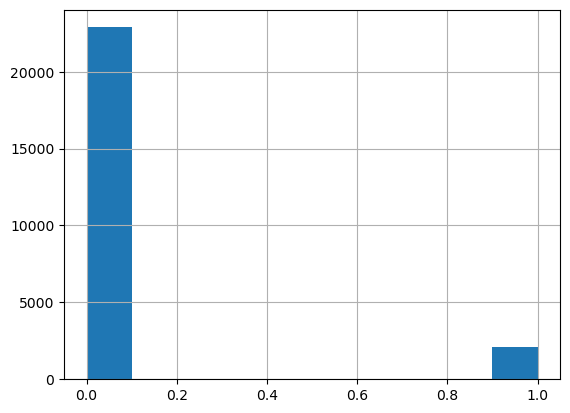

In [16]:
df['TARGET'].hist()

In [17]:
disbalance_coefficient = df[df.TARGET == 0].shape[0] / df[df.TARGET == 1].shape[0]
disbalance_coefficient

10.842728564661298

##### To fight the imbalance, we will use the weightning method during training. Moreover, let's use the upsampling method for the minor class

##### But it would be correct to apply it to the train data only, so first let's split the data

## Data split

In [18]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(columns=['TARGET']),
    df['TARGET'],
    test_size=0.25,
    stratify=df['TARGET'],
    random_state=SEED
)

X_train.shape

(18750, 184)

# Straight to the business: let's fit a Logistic Regression!
###### But without fighting the class imbalance

In [19]:
logistic_regression_model = LogisticRegression(C=1e9)

logistic_regression_model.fit(X_train, y_train)
predictions = logistic_regression_model.predict(X_test)
print('RocAuc:', roc_auc(y_test, predictions))
print('Precision:', precision(y_test, predictions))

RocAuc: 0.5
Precision: 0.0


/Users/iliakozhevnikov/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/iliakozhevnikov/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Didn't work, let's use sampling and weightening

In [20]:
train_data = pd.concat(
    [
        X_train,
        y_train
    ], axis=1
)
train_data = pd.concat(
    [
        train_data[train_data.TARGET == 0].sample(int(train_data[train_data.TARGET == 0].shape[0] * 0.33)),
        train_data[train_data.TARGET == 1].sample(train_data[train_data.TARGET == 1].shape[0] * 2, replace=True)
    ], axis=0
).sample(frac=1)
X_train, y_train = train_data.drop(columns=['TARGET']), train_data['TARGET']

<Axes: >

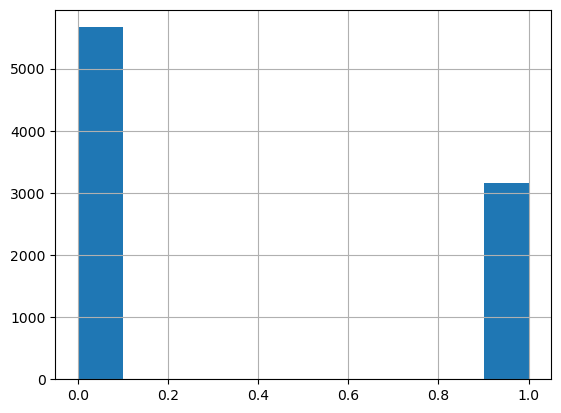

In [21]:
train_data['TARGET'].hist()

##### A bit better

# Logistic Regression

In [22]:
logistic_regression_model = LogisticRegression(C=1e9, class_weight={0:1,1:2})

logistic_regression_model.fit(X_train, y_train)
predictions = logistic_regression_model.predict(X_test)
print('RocAuc:', roc_auc(y_test, predictions))
print('Precision:', precision(y_test, predictions))

RocAuc: 0.5598318690222744
Precision: 0.10304975922953451


/Users/iliakozhevnikov/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


# SVM

In [23]:
svm_model = svc(class_weight={0:1,1:2})

svm_model.fit(X_train, y_train)
predictions = svm_model.predict(X_test)
print('RocAuc:', roc_auc(y_test, predictions))
print('Precision:', precision(y_test, predictions))

RocAuc: 0.5449560706682343
Precision: 0.09507557289127255


### As we can see, target classes are hardy linearly separable. So, let's try a bit more complicated models

# CatBoost

In [24]:
cb_model = CatBoostClassifier(
    iterations=5000,
    depth=6,
    class_weights={0:1,1:4},
    early_stopping_rounds=100
)
cb_model.fit(X_train, y_train, verbose=500)
predictions = cb_model.predict(X_test)
predictions_pr = cb_model.predict_proba(X_test)[:, 1]
print('RocAuc:', roc_auc(y_test, predictions_pr))
print('Precision:', precision(y_test, predictions))

Learning rate set to 0.005969
0:	learn: 0.6917095	total: 64.2ms	remaining: 5m 21s
500:	learn: 0.5062742	total: 2.08s	remaining: 18.6s
1000:	learn: 0.4645713	total: 4.27s	remaining: 17s
1500:	learn: 0.4322384	total: 6.6s	remaining: 15.4s
2000:	learn: 0.3960964	total: 8.88s	remaining: 13.3s
2500:	learn: 0.3638332	total: 11.2s	remaining: 11.2s
3000:	learn: 0.3366187	total: 13.3s	remaining: 8.84s
3500:	learn: 0.3115532	total: 15.3s	remaining: 6.56s
4000:	learn: 0.2883568	total: 17.4s	remaining: 4.33s
4500:	learn: 0.2679972	total: 19.4s	remaining: 2.15s
4999:	learn: 0.2500364	total: 21.5s	remaining: 0us
RocAuc: 0.7013023895014457
Precision: 0.15065403698691926


#### To get a better precision score, we can choose the probability threshold

In [25]:
cb_model.set_probability_threshold(.75)

predictions = cb_model.predict(X_test)
predictions_pr = cb_model.predict_proba(X_test)[:, 1]
print('RocAuc:', roc_auc(y_test, predictions_pr))
print('Precision:', precision(y_test, predictions))

RocAuc: 0.7013023895014457
Precision: 0.21804511278195488


# XGBoost

In [26]:
xgb_model = XGBClassifier(
    n_estimators=5000,
    max_depth=6,
)

weight_ratio = 0.85
w_array = np.array([1] * y_train.shape[0])
w_array[y_train==1] = weight_ratio
w_array[y_train==0] = 1- weight_ratio

xgb_model.fit(
    X_train,
    y_train,
#     sample_weight=w_array
)
predictions = xgb_model.predict(X_test)
predictions_pr = xgb_model.predict_proba(X_test)[:, 1]
print('RocAuc:', roc_auc(y_test, predictions_pr))
print('Precision:', precision(y_test, predictions))

RocAuc: 0.6676371368349697
Precision: 0.20108695652173914


# RandomForest

In [27]:
rf_model = RandomForestClassifier(
    n_estimators=1000,
    max_depth=15,
    class_weight={0:1,1:6}
)

rf_model.fit(X_train, y_train)
predictions = rf_model.predict(X_test)
predictions_pr = rf_model.predict_proba(X_test)[:, 1]
print('RocAuc:', roc_auc(y_test, predictions_pr))
print('Precision:', precision(y_test, predictions))

RocAuc: 0.6915520108459641
Precision: 0.13954402515723272


## MLP

In [28]:
input_size = X_train.shape[1]
output_size = 1

epochs_num = 500
lr = 0.0001
batch_size = 512
shuffle = True

mlp_model = torch.nn.Sequential(
    torch.nn.Linear(input_size, 128),
    torch.nn.Dropout(0.3),
    torch.nn.Sigmoid(),
    torch.nn.Linear(128, 64),
    torch.nn.Dropout(0.3),
    torch.nn.Sigmoid(),
    torch.nn.Linear(64, output_size),
    torch.nn.Dropout(0.3),
    torch.nn.Sigmoid()
)

optimizer = torch.optim.Adam(params=mlp_model.parameters(), lr=lr)
loss = torch.nn.BCEWithLogitsLoss()
verbose = 100

train_df = pd.concat(
    [X_train, y_train], axis=1
)

train_dataloader = torch.utils.data.DataLoader(
    torch.from_numpy(train_df.to_numpy().astype(np.float64)),
    batch_size=batch_size,
    shuffle=shuffle,
)
test_dataloader = torch.utils.data.DataLoader(
    torch.from_numpy(pd.concat([X_test, y_test], axis=1).to_numpy().astype(np.float64)),
    batch_size=batch_size,
    shuffle=shuffle,
)

mlp_model.train()
for epoch in range(epochs_num):
    optimizer.zero_grad()
    avg_epoch_loss = 0
    avg_epoch_auc_roc = 0
    avg_epoch_precision = 0

    for batch in train_dataloader:
        X, y = batch[:, :-1], batch[:, -1].unsqueeze(1)
        pred = mlp_model(X.to(torch.float32)).to(torch.float64)
        l = loss(y, pred)

        l.backward()
        optimizer.step()

    mlp_model.eval()
    for batch in test_dataloader:
        X, y = batch[:, :-1], batch[:, -1].unsqueeze(1)
        pred = mlp_model(X.to(torch.float32)).to(torch.float64)
        l = loss(y, pred)
        avg_epoch_loss += l.item() / (X_test.shape[0] // batch_size)
        avg_epoch_auc_roc += roc_auc(y, pred.detach().numpy()) / (X_test.shape[0] // batch_size)
        binarized_predictions = np.array(list(map(lambda val: 0 if val < .5 else 1, pred.detach().numpy())))
        avg_epoch_precision += precision(y, binarized_predictions) / (X_test.shape[0] // batch_size)


    if epoch % verbose == 0 or epoch == epochs_num - 1 or (epoch < 100 and epoch % 10 == 0):
        print(f'Epoch {epoch}, avg test loss: {round(avg_epoch_loss, 5)}, avg test auc_roc_score: {avg_epoch_auc_roc}, avg test precision: {avg_epoch_precision}')

Epoch 0, avg test loss: 0.74422, avg test auc_roc_score: 0.5550403648535375, avg test precision: 0.08967791863207547
Epoch 10, avg test loss: 0.72572, avg test auc_roc_score: 0.5678626834343413, avg test precision: 0.09092472484276728
Epoch 20, avg test loss: 0.72042, avg test auc_roc_score: 0.5920978479836484, avg test precision: 0.09217153105345913
Epoch 30, avg test loss: 0.71848, avg test auc_roc_score: 0.5796715901318283, avg test precision: 0.09279493415880503
Epoch 40, avg test loss: 0.71828, avg test auc_roc_score: 0.5737705432453906, avg test precision: 0.09092472484276728
Epoch 50, avg test loss: 0.71709, avg test auc_roc_score: 0.5887948442469411, avg test precision: 0.09279493415880503
Epoch 60, avg test loss: 0.71745, avg test auc_roc_score: 0.5739834749252929, avg test precision: 0.09092472484276728
Epoch 70, avg test loss: 0.71723, avg test auc_roc_score: 0.5847793859678373, avg test precision: 0.09092472484276728
Epoch 80, avg test loss: 0.7173, avg test auc_roc_score: 

# Features importance evaluation

In [49]:
cb_model.get_feature_importance(prettified=True)

,Feature Id,Importances
0,EXT_SOURCE_3,8.392112
1,EXT_SOURCE_2,8.112277
2,AMT_ANNUITY,5.753041
3,DAYS_BIRTH,5.511635
4,DAYS_ID_PUBLISH,4.868523
...,...,...
179,ORGANIZATION_TYPE_Industry: type 5,0.000000
180,ORGANIZATION_TYPE_Industry: type 6,0.000000
181,ORGANIZATION_TYPE_Industry: type 8,0.000000
182,ORGANIZATION_TYPE_Legal Services,0.000000


In [50]:
explainer_cb = shap.Explainer(cb_model.predict, X_test)
shap_values_cb = explainer_cb(X_test)

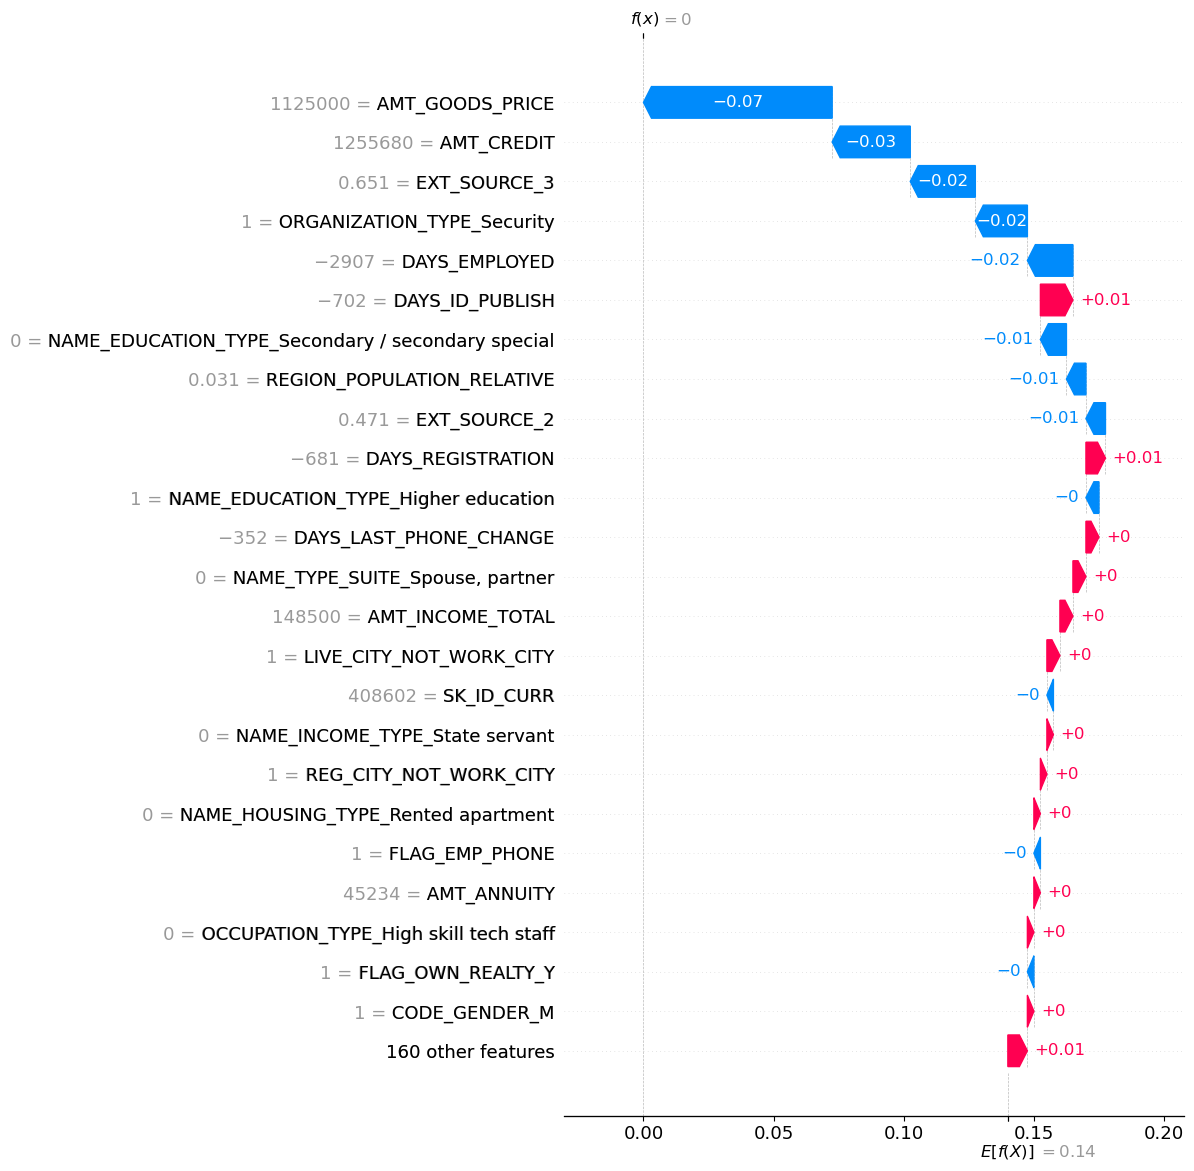

In [51]:
shap.plots.waterfall(shap_values_cb[1], max_display=25)

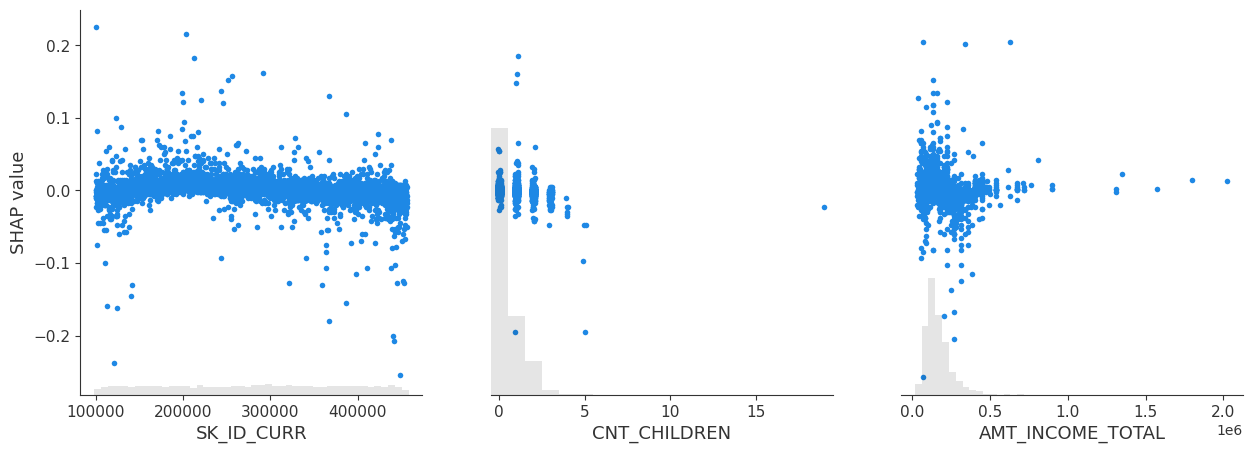

In [57]:
shap.plots.scatter(shap_values_cb[:, :3])

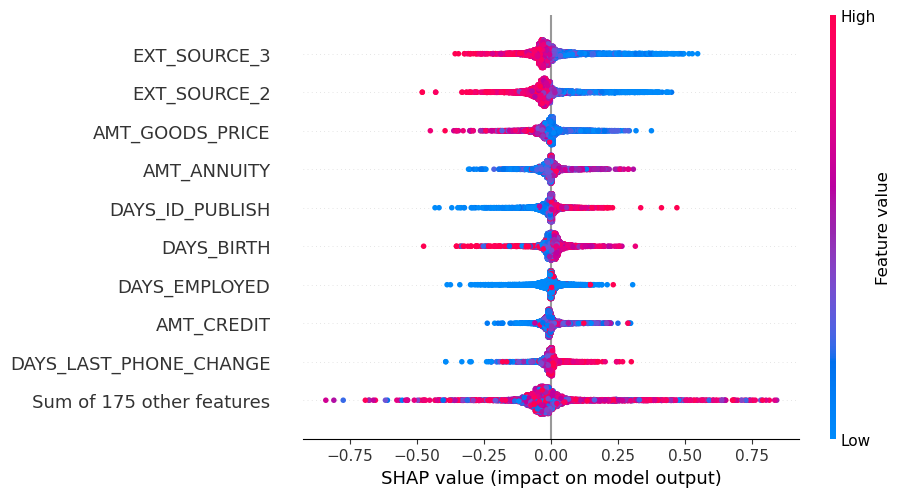

In [58]:
shap.plots.beeswarm(shap_values_cb)

# Results

So, we succeeded to perform the full pipeline of data preparation, preprocessing, imputing, fighting the class imbalance and, finally, we fitted 6 different models.

To evaluate them we used two metrics: AucRoc and Precision.

In the case of AucRoc it's clear, why we used it: since we have a harsh class imbalance, we want to use some metric that doesn't depend on the ratio between number of samples in each class.
As for the Precision, we decided to use it, since the business, for which we did these models, would rather not give a loan to a potential customer, than give it to someone who will not be able to return the debt. Thus, making too many False-Positive predictions would be disastrous for the business, so we focused on the precision score.

As for the models' quality, as usual, CatBoostClassifier won.

It shows the best AucRoc and, with chosen threshold, the best Precision score.
And at the same time it is not the slowest model to fit, so CatBoost holds the victory!